# Matched Control Subjects Analysis

Dataset gathered from control subjects, which were all healthy adults of a similar age range to patients. **TODO - ADD DESCRIPTION FOR MATCHED CONTROL SUBJECTS**


In [2]:
"""
Environment setup
"""
%matplotlib inline
%cd /lang_dec
import warnings; warnings.filterwarnings('ignore')
import hddm
import numpy as np
import matplotlib.pyplot as plt

from utils import model_tools

/Users/celefthe/Programming/projects/language_decision


In [3]:
# Import control subject data (as pandas dataframe)
controls_data = hddm.load_csv('/lang_dec/data/controls_clean.csv')

### Reaction Time & Accuracy 

Here we include the reaction time and accuracy metrics from the original dataset

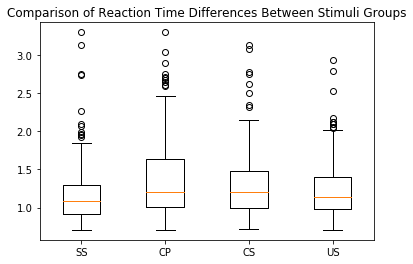

In [6]:
us = controls_data.loc[controls_data['stim'] == 'US']
ss = controls_data.loc[controls_data['stim'] == 'SS']
cp = controls_data.loc[controls_data['stim'] == 'CP']
cs = controls_data.loc[controls_data['stim'] == 'CS']

plt.boxplot([ss.rt.values, cp.rt.values, cs.rt.values, us.rt.values], 
            labels=('SS', 'CP', 'CS', 'US'),)
plt.title('Comparison of Reaction Time Differences Between Stimuli Groups')
plt.show()

In [7]:
ss_accuracy = (len([x for x in ss.response.values if x >= 1]) / len(ss.response.values)) * 100 
cp_accuracy = (len([x for x in cp.response.values if x >= 1]) / len(cp.response.values)) * 100
cs_accuracy = (len([x for x in cs.response.values if x >= 1]) / len(cs.response.values)) * 100
us_accuracy = (len([x for x in us.response.values if x >= 1]) / len(us.response.values)) * 100

print("SS Accuracy: " + str(ss_accuracy) + "%")
print("CP Accuracy: " + str(cp_accuracy) + "%")
print("CS Accuracy: " + str(cs_accuracy) + "%")
print("US Accuracy: " + str(us_accuracy) + "%")

SS Accuracy: 90.3954802259887%
CP Accuracy: 71.42857142857143%
CS Accuracy: 90.22988505747126%
US Accuracy: 97.14285714285714%


<Container object of 4 artists>

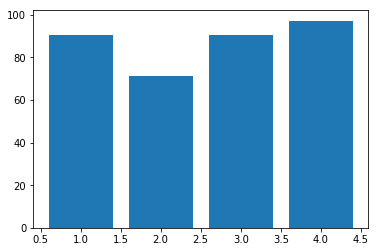

In [8]:
plt.bar([1,2,3,4], 
        [ss_accuracy, cp_accuracy, cs_accuracy, us_accuracy])

### Does the drift rate depend on stimulus type?


In [56]:
"""
Plot Drift Diffusion Model for controls
"""
controls_model = hddm.HDDM(controls_data, depends_on={'v': 'stim'}, bias=True)
controls_model.find_starting_values()
controls_model.sample(9000, burn=200, dbname='language_decision/models/controls', db='txt')

 [-----------------100%-----------------] 9000 of 9000 complete in 174.7 sec

#### Convergence Checks

Before carrying on with analysing the output of the model, we need to check that the markov chains have properly converged. There's a number of ways to do this, which the authors of the `hddm` library recommend$^1$. We'll begin by visually inspecting the MCMC posterior plots. 

Plotting a
Plotting a_std
Plotting v(CP)
Plotting v(CS)
Plotting v(SS)
Plotting v(US)
Plotting v_std
Plotting t
Plotting t_std
Plotting z
Plotting z_std


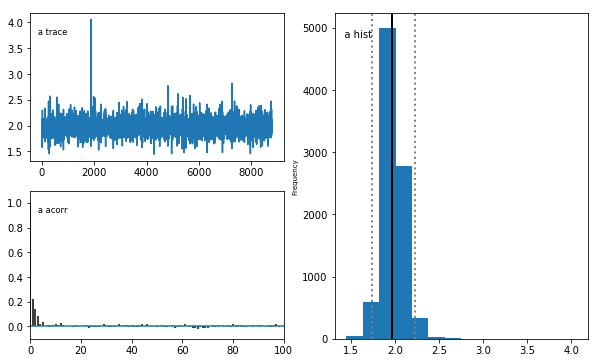

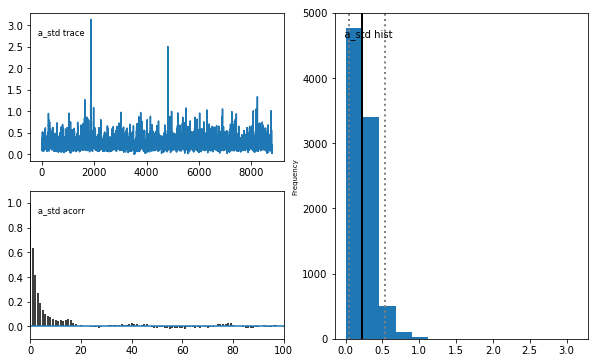

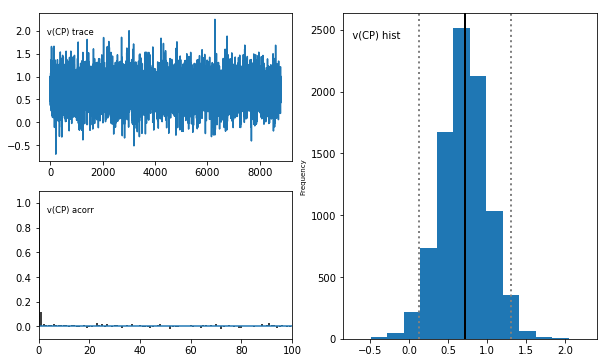

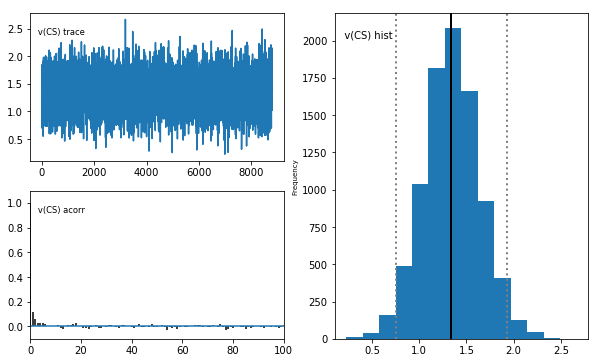

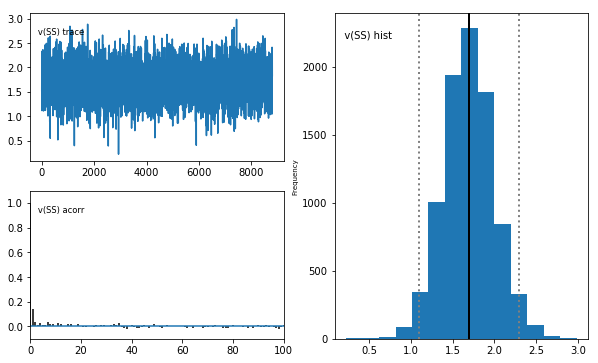

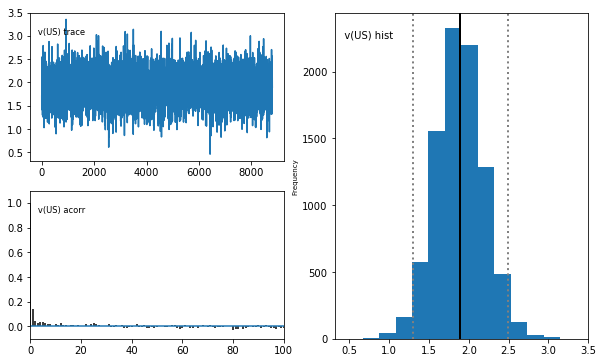

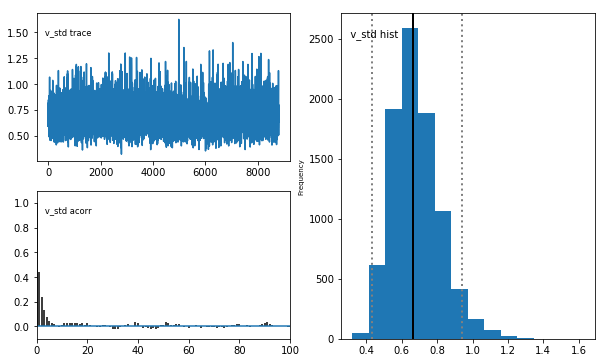

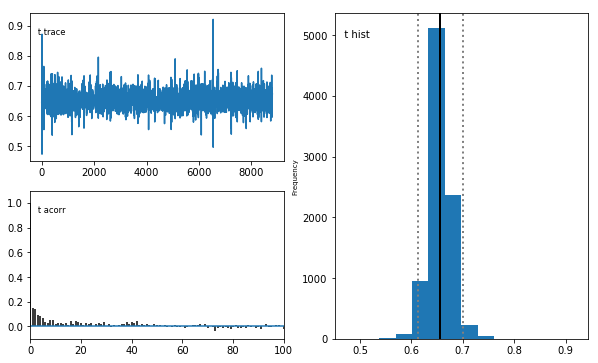

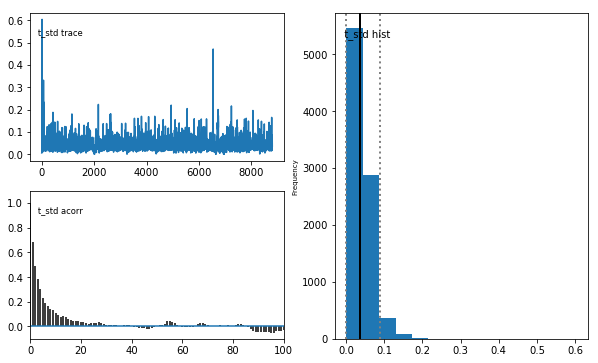

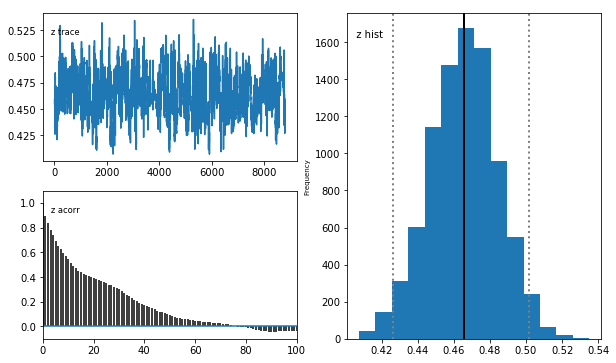

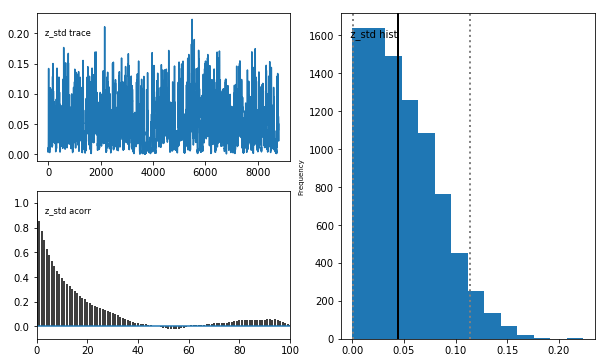

In [57]:
controls_model.plot_posteriors()

**PASS** - No problematic patterns, such as drifts or large jumps, can be in any of the traces above. Autocorrelation also drops to zero quite quickly when considering past samples - which is what we want.

We can also formally test for model convergence using the Gelman-Rubin R statistic$^2$, which compares the within- and between-chain variance of different runs of the same model; models converge if variables are between $0.98$ and $1.02$. A simple algorithm to check this is outlined below:

In [12]:
models = []
for i in range(5):
    m = hddm.HDDM(controls_data, depends_on={'v': 'stim'}, bias=True)
    m.find_starting_values()
    m.sample(6000, burn=20)
    models.append(m)
    
model_tools.check_convergence(models)

 [-----------------100%-----------------] 6000 of 6000 complete in 99.7 secc
No convergence problems detected!


True

**PASS** - Formal testing reveals no convergence problems; Gelman-Rubin R statistic values for all model variablesfall within the desired range ($0.98$ to $1.02$)

#### Drift Rate Analysis

Here, we examine whether the type of stimulus significantly affects the drift rate of the decision-making process.

In [59]:
controls_stats = controls_model.gen_stats()
print("Threshold (a) Mean: " + str(controls_stats['mean']['a']) + " (std: " + str(controls_stats['std']['a']) + ")")
print("Non-Decision (t) Mean: " + str(controls_stats['mean']['z']) + " (std: " + str(controls_stats['std']['z']) + ")")
print("Bias (z) Mean: " + str(controls_stats['mean']['t']) + " (std: " + str(controls_stats['std']['t']) + ")")
print("SS Mean Drift Rate: " + str(controls_stats['mean']['v(SS)']) + " (std: " + str(controls_stats['std']['v(SS)']) + ")")
print("CP Mean Drift Rate: " + str(controls_stats['mean']['v(CP)']) + " (std: " + str(controls_stats['std']['v(CP)']) + ")")
print("CS Mean Drift Rate: " + str(controls_stats['mean']['v(CS)']) + " (std: " + str(controls_stats['std']['v(CS)']) + ")")
print("US Mean Drift Rate: " + str(controls_stats['mean']['v(US)']) + " (std: " + str(controls_stats['std']['v(US)']) + ")")

Threshold (a) Mean: 1.97704061887 (std: 0.124933735719)
Non-Decision (t) Mean: 0.46542064386 (std: 0.0189337490142)
Bias (z) Mean: 0.655964118581 (std: 0.022025487066)
SS Mean Drift Rate: 1.69189787968 (std: 0.303077422736)
CP Mean Drift Rate: 0.708393431038 (std: 0.299664478018)
CS Mean Drift Rate: 1.3435491699 (std: 0.297573901488)
US Mean Drift Rate: 1.8874859417 (std: 0.302114937186)


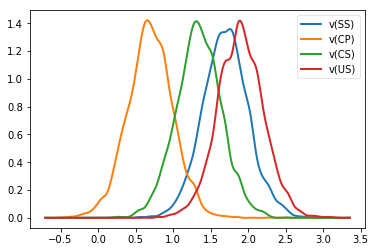

In [60]:
v_SS, v_CP, v_CS, v_US = controls_model.nodes_db.node[['v(SS)', 'v(CP)', 'v(CS)', 'v(US)']]

hddm.analyze.plot_posterior_nodes([v_SS, v_CP, v_CS, v_US])

In [61]:
print('P(SS > US) = ' + str((v_SS.trace() > v_US.trace()).mean()))
print('P(CP > SS) = ' + str((v_CP.trace() > v_SS.trace()).mean()))
print('P(CS > SS) = ' + str((v_CS.trace() > v_SS.trace()).mean()))
print('P(CP > CS) = ' + str((v_CP.trace() > v_CS.trace()).mean()))
print('P(CP > US) = ' + str((v_CP.trace() > v_US.trace()).mean()))
print('P(CS > US) = ' + str((v_CS.trace() > v_US.trace()).mean()))

P(SS > US) = 0.315
P(CP > SS) = 0.0105681818182
P(CS > SS) = 0.199090909091
P(CP > CS) = 0.06125
P(CP > US) = 0.00511363636364
P(CS > US) = 0.0948863636364


- The drift rate for **CP** is significantly lower than both **SS** and **US**; no significant difference detected for **CS**  
- No other statistical significance detected at $p <0.05$

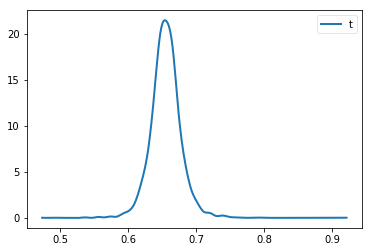

In [63]:
"""
Distribution for the non-decision time t
"""
time_nondec = controls_model.nodes_db.node[['t']]

hddm.analyze.plot_posterior_nodes(time_nondec)

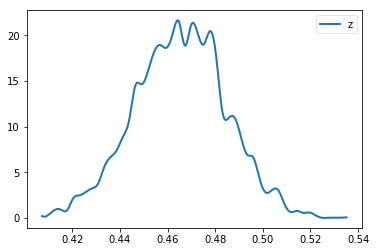

In [65]:
"""
Distribution of bias z
"""
z = controls_model.nodes_db.node[['z']]

hddm.analyze.plot_posterior_nodes(z)

### Does the stimulus type affect the distance  between the two boundaries (threshold)?

*Threshold* (or *a*) describes the relative difference in the distance between the upper and lower response boundaries of the DDM.

We explore whether stimulus type affects the threshold / distance between the two boundaries

In [6]:
controls_model_threshold = hddm.HDDM(controls_data, depends_on={'v': 'stim', 'a': 'stim'}, bias=True)
controls_model_threshold.find_starting_values()
controls_model_threshold.sample(10000, burn=200, dbname='language_decision/models/controls_threshold', db='txt')

 [-----------------100%-----------------] 10000 of 10000 complete in 274.6 sec

#### Convergence checks

In [72]:
models_threshold = []
for i in range(5):
    m = hddm.HDDM(controls_data, depends_on={'v': 'stim', 'a': 'stim'})
    m.find_starting_values()
    m.sample(6000, burn=20)
    models_threshold.append(m)
    
model_tools.check_convergence(models_threshold)

 [-----------------100%-----------------] 6000 of 6000 complete in 125.2 sec
No convergence problems detected!


True

#### Threshold analysis

Since models converge, we can check the posteriors for significant differences in threshold between stimuli groups as we did for drift rates.

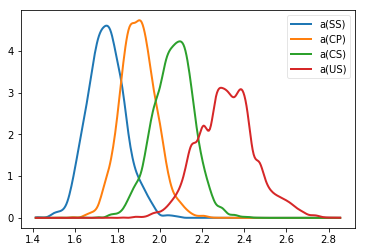

In [7]:
a_SS, a_CP, a_CS, a_US = controls_model_threshold.nodes_db.node[['a(SS)', 'a(CP)', 'a(CS)', 'a(US)']]

hddm.analyze.plot_posterior_nodes([a_SS, a_CP, a_CS, a_US])

In [73]:
print('P(SS > US) = ' + str((a_SS.trace() > a_US.trace()).mean()))
print('P(SS > CS) = ' + str((a_SS.trace() > a_CS.trace()).mean()))
print('P(CP > SS) = ' + str((a_CP.trace() > a_SS.trace()).mean()))
print('P(CP > CS) = ' + str((a_CP.trace() > a_CS.trace()).mean()))
print('P(CP > US) = ' + str((a_CP.trace() > a_US.trace()).mean()))
print('P(CS > US) = ' + str((a_CS.trace() > a_US.trace()).mean()))

P(SS > US) = 0.0
P(SS > CS) = 0.0158163265306
P(CP > SS) = 0.833367346939
P(CP > CS) = 0.0722448979592
P(CP > US) = 0.000612244897959
P(CS > US) = 0.0238775510204


- The threshold value of **CS** is significantly lower than that of **US** (p=0.0397)   
- The threshold value of **CP** is significantly lower than **US** (p=0.00194)  
- The threshold value of **SS** is significantly lower than **US** (p=0.000306)  
- The threshold value of **SS** is significantly lower than **CS** (p=0.0189)  

The threshold for **US** is not well defined (large width, no discreet peak)

In [74]:
print("a(US) mean: " + str(a_US.trace().mean()))
print("a(SS) mean: " + str(a_SS.trace().mean()))
print("a(CS) mean: " + str(a_CS.trace().mean()))
print("a(CP) mean: " + str(a_CP.trace().mean()))


a(US) mean: 2.35914843334
a(SS) mean: 1.77851222155
a(CS) mean: 2.06205314612
a(CP) mean: 1.88590603569


## Lumped Model

In [8]:
controls_model_lumped = hddm.HDDM(controls_data)
controls_model_lumped.find_starting_values()
controls_model_lumped.sample(10000, burn=200, dbname='language_decision/models/controls_lumped', db='txt')

 [-----------------100%-----------------] 10000 of 10000 complete in 89.2 sec

Plotting a
Plotting a_std
Plotting v
Plotting v_std
Plotting t
Plotting t_std


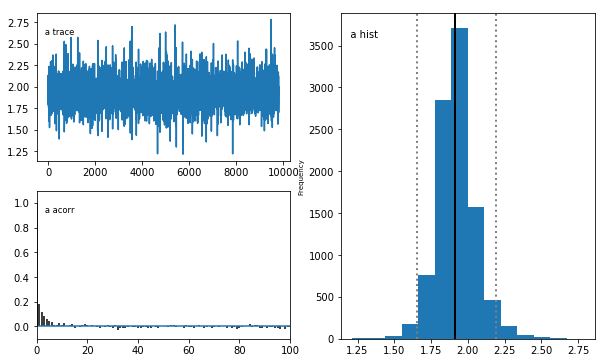

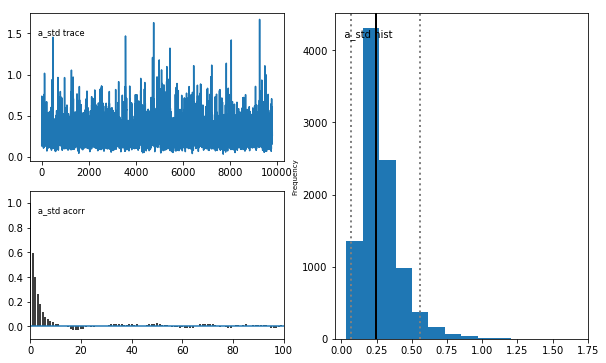

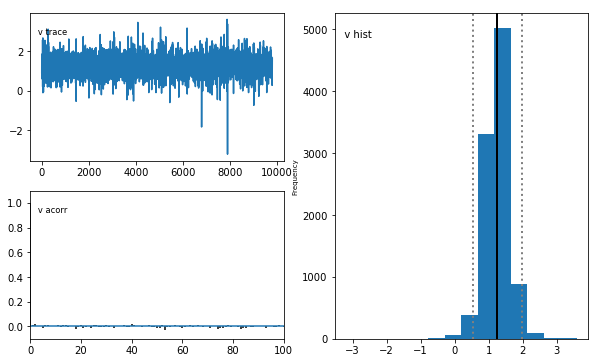

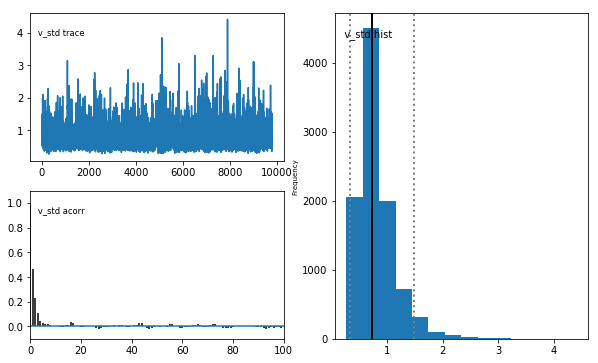

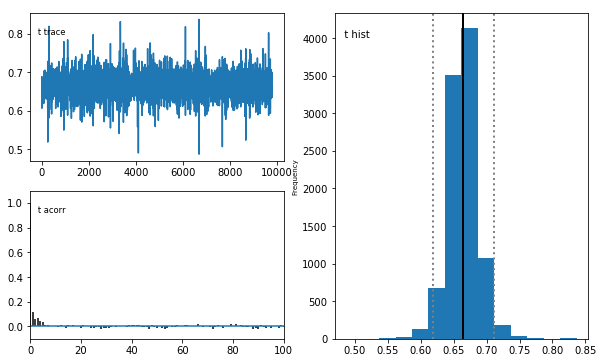

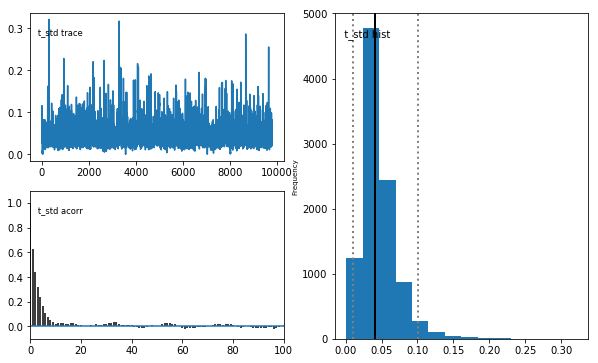

In [9]:
controls_model_lumped.plot_posteriors()